# Module 3 — Flower Classification (Expanded)

This expanded notebook covers:

- download and prepare a flower dataset (TensorFlow 'flower_photos' example)
- using `image_dataset_from_directory` for train/validation split
- transfer learning with MobileNetV2 (feature extraction + fine-tuning)
- training (short demo), evaluation and saving model

Notes for instructors: if dataset download fails due to network restrictions, replace dataset_dir with your Drive path or upload a small subset of images to Colab.

## 1 — Setup (install packages and imports)

In [1]:
# Install packages (albumentations optional) - may be skipped if already present
!pip -q install -U tensorflow==2.12.0 --quiet
!pip -q install -U tensorflow-io --quiet

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

print('TF version:', tf.__version__)
print('GPU available:', tf.config.list_physical_devices('GPU'))


ERROR: Could not find a version that satisfies the requirement tensorflow==2.12.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.12.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 108.9 MB/s eta 0:00:00
TF version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 2 — Download/prepare the Flowers dataset
We'll try to download the TensorFlow `flower_photos` dataset. If internet is not available in your runtime, upload your dataset to Drive and set `dataset_dir` accordingly.

In [2]:
# Attempt to download TF example flower_photos dataset (approx 80MB)
import pathlib

dataset_url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
try:
    data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
    data_dir = pathlib.Path(data_dir)
    print('Dataset downloaded to', data_dir)
except Exception as e:
    print('Could not download dataset automatically. Error:', e)
    # Fallback: instruct user to upload dataset to /content/flowers or mount Drive
    data_dir = pathlib.Path('/content/flowers')
    print('Set data_dir =', data_dir)

# Show class folders if dataset exists
if data_dir.exists():
    classes = [p.name for p in data_dir.iterdir() if p.is_dir()]
    print('Found classes:', classes)
else:
    print('Dataset directory not found. Please upload dataset to', data_dir)


228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step
Dataset downloaded to /root/.keras/datasets/flower_photos
Found classes: ['flower_photos']


## 3 — Create training and validation datasets with `image_dataset_from_directory`

Found 3670 files belonging to 1 classes.
Using 2936 files for training.
Found 3670 files belonging to 1 classes.
Using 734 files for validation.
Classes: ['flower_photos']


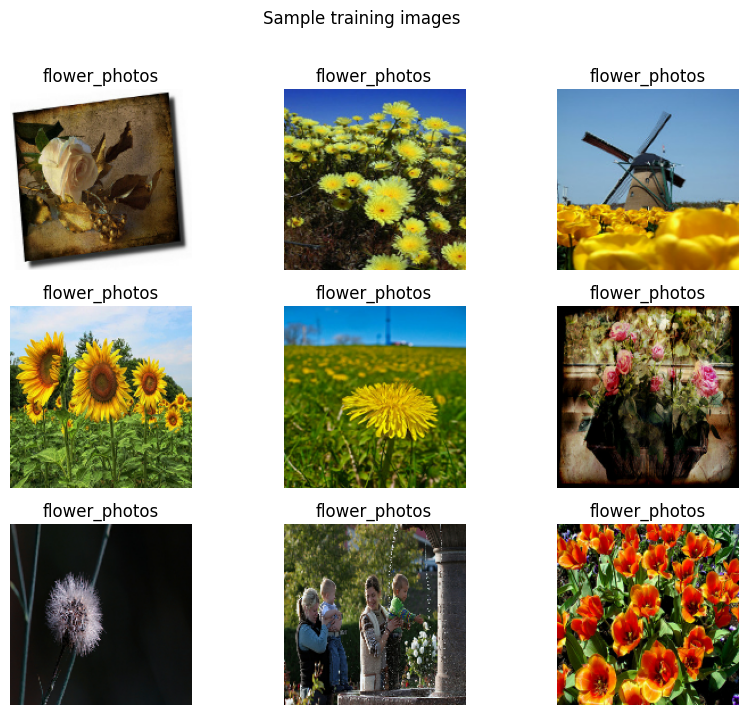

In [3]:
# Parameters
img_size = (160,160)
batch_size = 32

from tensorflow.keras.preprocessing import image_dataset_from_directory

if data_dir.exists():
    train_ds = image_dataset_from_directory(str(data_dir), validation_split=0.2, subset='training', seed=123, image_size=img_size, batch_size=batch_size)
    val_ds = image_dataset_from_directory(str(data_dir), validation_split=0.2, subset='validation', seed=123, image_size=img_size, batch_size=batch_size)
    class_names = train_ds.class_names
    print('Classes:', class_names)
else:
    print('No dataset found — please upload and re-run this cell')

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# Visualize a few examples
plt.figure(figsize=(10,8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')
plt.suptitle('Sample training images')
plt.show()


## 4 — Build transfer learning model (MobileNetV2 feature extractor)

In [4]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

num_classes = len(class_names) if 'class_names' in globals() else 5

base_model = MobileNetV2(input_shape=(img_size[0], img_size[1], 3), include_top=False, weights='imagenet')
base_model.trainable = False  # feature extraction

inputs = layers.Input(shape=(img_size[0], img_size[1], 3))
# normalize inputs to [0,1]
x = layers.Rescaling(1./255)(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model = models.Model(inputs, outputs)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## 5 — Train the classifier head (short demo)

Epoch 1/4


/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


92/92 ━━━━━━━━━━━━━━━━━━━━ 46s 315ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/4
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/4
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/4
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 83ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


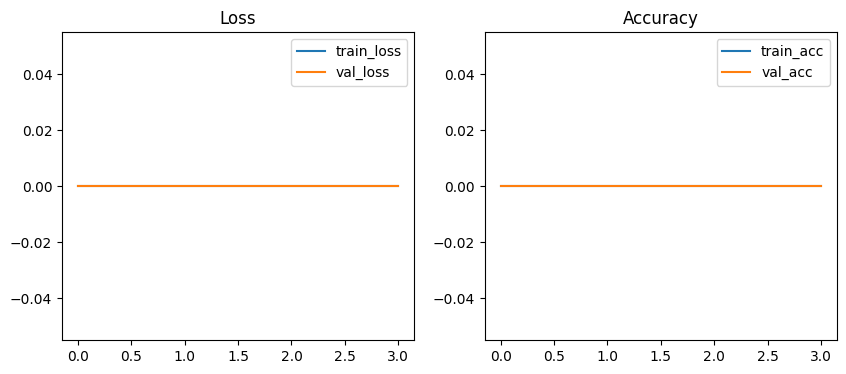

In [5]:
# Train for a few epochs (demo). Increase epochs for real training.
epochs = 4
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

# Plot metrics
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy')
plt.show()


## 6 — Evaluate and show some predictions

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Validation loss, acc: 0.0 0.0


/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


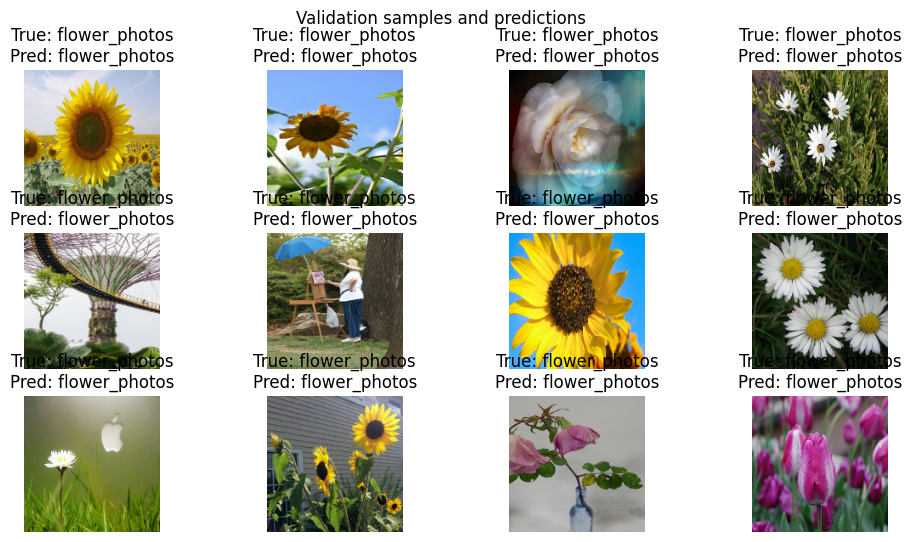

In [6]:
loss, acc = model.evaluate(val_ds)
print('Validation loss, acc:', loss, acc)

# Show predictions on a few validation images
for images, labels in val_ds.take(1):
    preds = model.predict(images)
    pred_labels = np.argmax(preds, axis=1)
    plt.figure(figsize=(12,6))
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(f'True: {class_names[labels[i]]}\nPred: {class_names[pred_labels[i]]}')
        plt.axis('off')
    plt.suptitle('Validation samples and predictions')
    plt.show()
    break


## 7 — Optional: Unfreeze top layers and fine-tune

In [7]:
# Unfreeze some of the top layers of the base model for fine-tuning
base_model.trainable = True
# Freeze all layers except the last N
fine_tune_at = len(base_model.layers) - 30
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fine-tune for a few epochs (demo)
fine_epochs = 3
total_epochs = epochs + fine_epochs
history_fine = model.fit(train_ds, validation_data=val_ds, epochs=total_epochs, initial_epoch=epochs)


Epoch 5/7
92/92 ━━━━━━━━━━━━━━━━━━━━ 35s 210ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/7
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/7
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


## 8 — Save model for later inference

In [8]:
save_path = '/mnt/data/flower_mobilenetv2.h5'
model.save(save_path)
print('Saved model to', save_path)


Saved model to /mnt/data/flower_mobilenetv2.h5


## 9 — Instructor Tips & Exercises

- If dataset download fails, upload a small folder with class subfolders to `/content/flowers` or mount Google Drive and point `data_dir` to it.
- Exercises:
  1. Increase training epochs and observe improvement.
  2. Try heavier augmentation (tf.image or Albumentations) and compare results.
  3. Compare MobileNetV2 with EfficientNetB0 for speed/accuracy trade-off.
  4. Export model to SavedModel or TFLite for deployment demos.
